# Libraries

In [134]:
import pandas as pd
import numpy as np 
import plotly.express as px
import plotly.graph_objects as go
import matplotlib as mpl
import matplotlib.pyplot as plt 
import seaborn as sns
import statsmodels.api as sm 
import os
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.manifold import TSNE

from imblearn.over_sampling import SMOTE
from collections import Counter

In [135]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}

sns.set_theme(context = 'talk',  
              style = 'darkgrid',  
              font = 'Malgun Gothic', 
              font_scale = 1.2,         
              rc = custom_params) 

# Data Read

In [136]:
cur_dir = os.getcwd()

print(cur_dir)
for roots, folders, files in os.walk(cur_dir):
    if '.git' not in roots:
        print(roots, files)

c:\Users\user\Documents\ML
c:\Users\user\Documents\ML ['.gitignore', '1company_rating.ipynb', '1Heart_Disease.ipynb', '1Insurance_charge.ipynb', '1project_pre.ipynb', 'graph.txt', 'Libraries.ipynb', 'Mv_txt.ipynb', 'pre.txt', 'scikit-learn.ipynb', 'SMOTE-Oversampling.ipynb', 'validation.ipynb', '분석기법별 특징.png']
c:\Users\user\Documents\ML\.vscode ['settings.json']
c:\Users\user\Documents\ML\data ['bestsellers with categories.csv', 'Book_description.npy', 'Companies_Dataset.csv', 'Companies_Dataset.xlsx', 'heart_disease_uci.csv', 'insurance.csv']


In [137]:
data_list = os.listdir(cur_dir + "\data")
Dataset = dict()

for data in data_list:
    if '.csv' in data:
        Dataset[data[:-4]] = pd.read_csv(cur_dir + f"\data\{data}")

In [138]:
hdu = Dataset['heart_disease_uci']
df = hdu.copy()

In [139]:
df.head(3)

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1


# Data info

In [140]:
na_count = df.isna().sum().reset_index()
dtypes_df = df.dtypes.reset_index()
unique_count = df.nunique().reset_index()

df_info = pd.merge(na_count, unique_count, on = "index", how = "left")
df_info = pd.merge(df_info, dtypes_df, on = "index", how = "left")

df_info = df_info.rename(columns = {"index":"col", "0_x":"null_count", "0_y":"unique_count", 0:"dtypes"})
df_info['null_ratio'] = round(df_info['null_count'] / len(df) * 100, 2)
df_info = df_info[['col', 'null_count', 'null_ratio', 'unique_count', 'dtypes']]

print(f"전체\nIndex: {df.shape[0]}개\n\nColumns: {df.shape[1]}개")
df_info

전체
Index: 920개

Columns: 16개


,col,null_count,null_ratio,unique_count,dtypes
0,id,0,0.00,920,int64
1,age,0,0.00,50,int64
2,sex,0,0.00,2,object
3,dataset,0,0.00,4,object
4,cp,0,0.00,4,object
5,trestbps,59,6.41,61,float64
6,chol,30,3.26,217,float64
7,fbs,90,9.78,2,object
8,restecg,2,0.22,3,object
9,thalch,55,5.98,119,float64


* ca, thal, slope 순으로 결측치 존재          
* numeric과 object 타입 컬럼 존재(인코딩 필요)
* num = Target

In [141]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,920.0,460.500000,265.725422,1.0,230.75,460.5,690.25,920.0
age,920.0,53.510870,9.424685,28.0,47.00,54.0,60.00,77.0
trestbps,861.0,132.132404,19.066070,0.0,120.00,130.0,140.00,200.0
chol,890.0,199.130337,110.780810,0.0,175.00,223.0,268.00,603.0
thalch,865.0,137.545665,25.926276,60.0,120.00,140.0,157.00,202.0
oldpeak,858.0,0.878788,1.091226,-2.6,0.00,0.5,1.50,6.2
ca,309.0,0.676375,0.935653,0.0,0.00,0.0,1.00,3.0
num,920.0,0.995652,1.142693,0.0,0.00,1.0,2.00,4.0


# EDA

## Dtypes 별

### Numeric

In [142]:
Num_df = df.select_dtypes(include = 'number').drop(columns = {'id'})
Num_df.head(2)

,age,trestbps,chol,thalch,oldpeak,ca,num
0,63,145.0,233.0,150.0,2.3,0.0,0
1,67,160.0,286.0,108.0,1.5,3.0,2


In [143]:
q = Num_df['age'].reset_index().rename(columns = {"index":"y"}).sort_values(by = 'age')
q['y'] = 1
q

,y,age
303,1,28
305,1,29
132,1,29
304,1,29
306,1,30
...,...,...
795,1,75
845,1,76
257,1,76
751,1,77


In [144]:
for q, col in enumerate((Num_df)):
    q = Num_df[col].reset_index().rename(columns = {"index":"y"}).sort_values(by = col)
    q['y'] = 1
    fig  = px.histogram(data_frame = Num_df, 
                        x = q[col], 
                        y = q['y'],
                        marginal = 'box',
                        nbins = q[col].nunique(),
                        color_discrete_sequence = ['#3F72AF'])
    fig.update_layout(title = col, bargap = 0.1)
    fig.show()

### Categorical

In [145]:
cat_df = df.select_dtypes(include = 'object')
cat_df.head(2)

,sex,dataset,cp,fbs,restecg,exang,slope,thal
0,Male,Cleveland,typical angina,True,lv hypertrophy,False,downsloping,fixed defect
1,Male,Cleveland,asymptomatic,False,lv hypertrophy,True,flat,normal


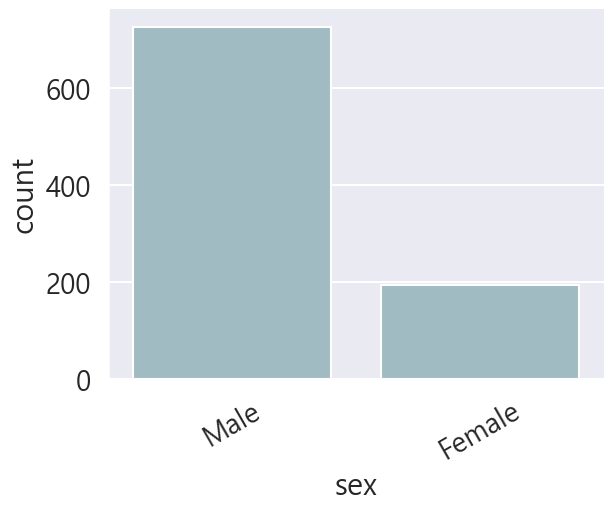

        count
sex          
Male      726
Female    194


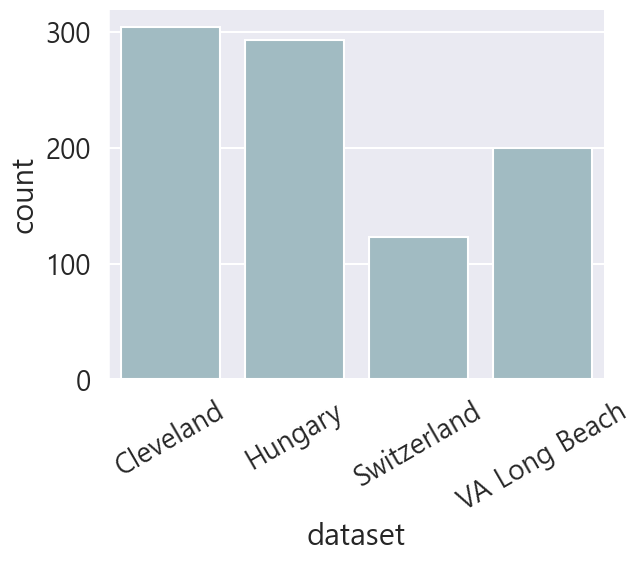

               count
dataset             
Cleveland        304
Hungary          293
VA Long Beach    200
Switzerland      123


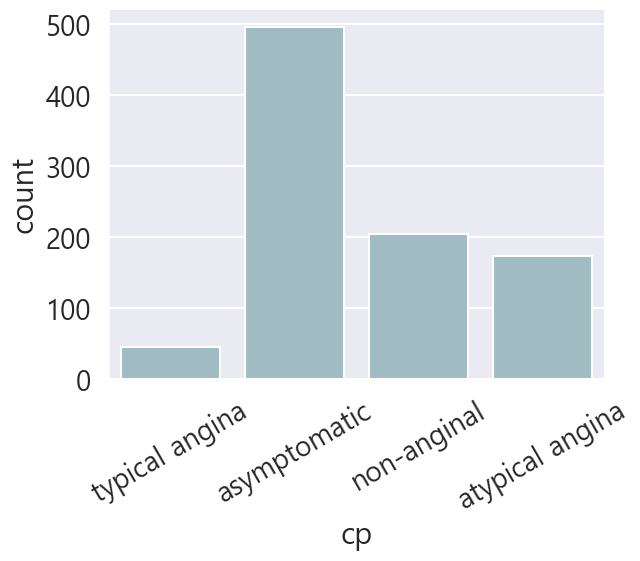

                 count
cp                    
asymptomatic       496
non-anginal        204
atypical angina    174
typical angina      46


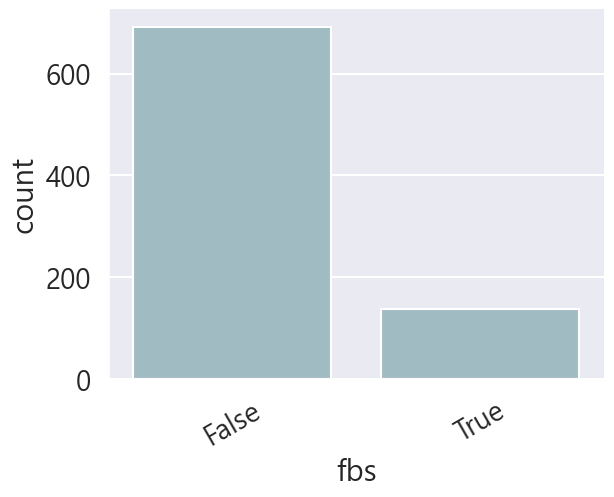

       count
fbs         
False    692
True     138


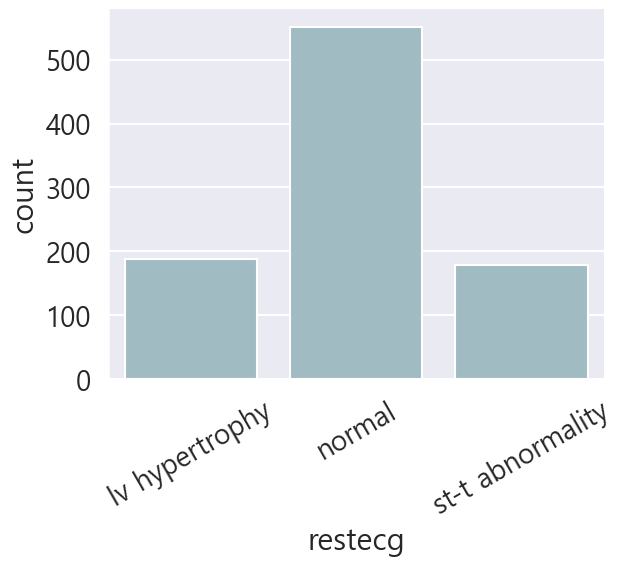

                  count
restecg                
normal              551
lv hypertrophy      188
st-t abnormality    179


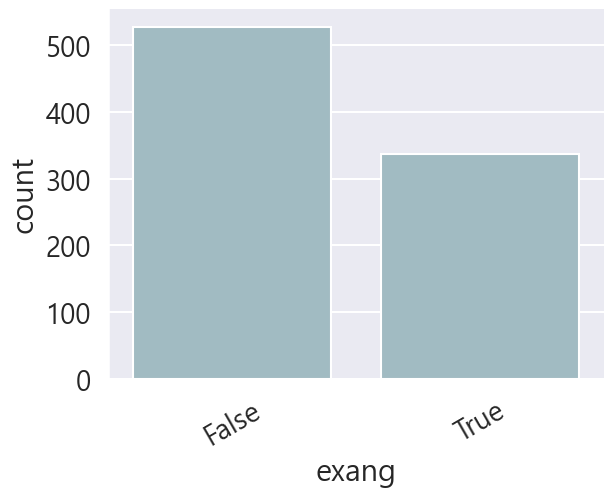

       count
exang       
False    528
True     337


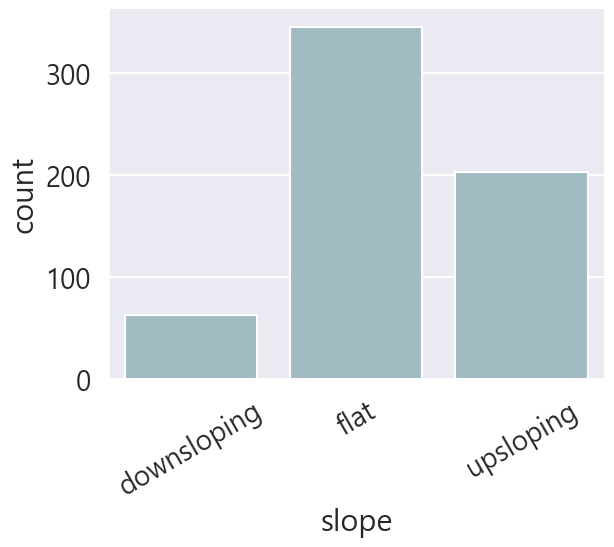

             count
slope             
flat           345
upsloping      203
downsloping     63


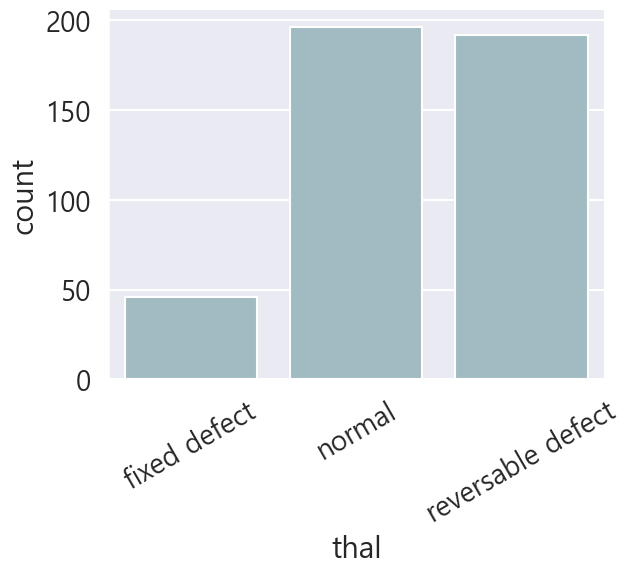

                   count
thal                    
normal               196
reversable defect    192
fixed defect          46


In [146]:
for col in cat_df:
    sns.countplot(data = cat_df, x = col, color = '#9BBEC8')
    plt.xticks(rotation = 30)
    plt.show()
    print(df[col].value_counts().reset_index().set_index(col))

## Column 별 [missing_value %]

### num(Target)

In [147]:
df.num.describe().reset_index()

,index,num
0,count,920.000000
1,mean,0.995652
2,std,1.142693
3,min,0.000000
4,25%,0.000000
5,50%,1.000000
6,75%,2.000000
7,max,4.000000


In [148]:
num_count = df.num.value_counts().reset_index()

In [149]:
fig = px.histogram(data_frame = num_count, 
                   x = num_count.num, 
                   y = num_count['count'],
                   color_discrete_sequence = ['#3F72AF'],
                   nbins = num_count.num.nunique(),
                   marginal = 'rug')
fig.update_layout(title = "Num", bargap = 0.1)
fig.show()

> Num = Target                 
* 0: 심장병 증상 없음
* 1 ~ 4: 증상 level과 type (숫자가 클 수록 악화)

### sex

In [150]:
px.histogram(df.sex,
             color_discrete_sequence = ["#3F72AF"])

In [151]:
df_sex = df.sex.value_counts().reset_index()
df_sex['sex_ratio'] = round(df.sex.value_counts().reset_index()['count'] / len(df), 2)
df_sex['sex_ratio'] = df_sex['sex_ratio'].astype('str')
df_sex['sex_ratio'] = df_sex['sex_ratio'] + "%"

In [152]:
df_sex

,sex,count,sex_ratio
0,Male,726,0.79%
1,Female,194,0.21%


* data 성비: 남자 79%, 여자 21%

### dataset

In [153]:
df.dataset.value_counts()

dataset
Cleveland        304
Hungary          293
VA Long Beach    200
Switzerland      123
Name: count, dtype: int64

> nation

### Age

In [154]:
df.age.describe()

count    920.000000
mean      53.510870
std        9.424685
min       28.000000
25%       47.000000
50%       54.000000
75%       60.000000
max       77.000000
Name: age, dtype: float64

In [155]:
df_age = df.age.value_counts().reset_index()

In [156]:
colors = ['lightslategrey'] * df.age.nunique()
colors[0] = 'blue'
colors[1] = 'blue'
colors[2] = 'blue'
colors[-1] = 'crimson'
colors[-2] = 'crimson'
colors[-3] = 'crimson'

trace = go.Bar(x = df_age.age,
               y = df_age['count'], 
               marker_color = colors, 
               marker_line_color='black')

data = [trace]
layout = go.Layout(title = "AGE")
go.Figure(data = data, layout = layout)

### CP(chest pain)

In [157]:
df.cp.describe()

count              920
unique               4
top       asymptomatic
freq               496
Name: cp, dtype: object

In [158]:
df_cp = df.cp.value_counts().reset_index()

In [159]:
px.bar(data_frame = df_cp, 
       x = df_cp['cp'],
       y = df_cp['count'])

> CP = 가슴통증          

* Asymptomatic: 심장병이 있음에도 불구하고 가슴통증이나 불편함이 없음
* Non-anginal: 심장병과 관련없는 가슴통증을 호소, 아마 근육이나 위장 같은 다른 요인들로 인한 통증일 것임
* Atypical angina: 협심증으로 인한 통증과 비슷한 통증이지만 그 주기, 강도, 트리거가 다름 typical angina로 분류 할 수 없는 증상
* typical angina: 가장 흔한 심장병 관련 가슴 통증 증상, 원인은 육체운동이나 스트레스

### Trestbps(혈압)[6]

In [160]:
df.trestbps.describe()

count    861.000000
mean     132.132404
std       19.066070
min        0.000000
25%      120.000000
50%      130.000000
75%      140.000000
max      200.000000
Name: trestbps, dtype: float64

In [161]:
fig = px.histogram(data_frame = df.trestbps,
                   nbins = df.trestbps.nunique(),
                   marginal = 'box',
                   color_discrete_sequence = ['#3F72AF'])
fig.update_layout(title = "혈압", bargap = 0.1)
fig.show()

> 혈압 0 = 이상치로 보임            
              
> 결측치 처리

In [162]:
df.loc[df.trestbps == 0, 'trestbps'] = np.nan

In [163]:
fig = px.histogram(data_frame = df.trestbps,
                   nbins = df.trestbps.nunique(),
                   marginal = 'box',
                   color_discrete_sequence = ['#3F72AF'])
fig.update_layout(title = "혈압", bargap = 0.1)
fig.show()

* 평범한 혈압은 통상적으로 120/80 mmhg 정도
* 편차가 크게 표준보다 낮거나 높은 혈압은 건강문제를 나타냄
* 고혈압은 심장병을 유발하고, 저혈압 또한 건강상 나쁘지만 심장병과는 거리가 멈

In [164]:
print(f"혈압\n\n평균: {df.trestbps.mean()}\n중간값: {df.trestbps.median()}")

혈압

평균: 132.28604651162792
중간값: 130.0


### Chol(총콜레스테롤 수치)[3]

In [165]:
df.chol.describe()

count    890.000000
mean     199.130337
std      110.780810
min        0.000000
25%      175.000000
50%      223.000000
75%      268.000000
max      603.000000
Name: chol, dtype: float64

In [166]:
df[df.chol == 0]

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
597,598,32,Male,Switzerland,typical angina,95.0,0.0,NaN,normal,127.0,False,0.7,upsloping,NaN,NaN,1
598,599,34,Male,Switzerland,asymptomatic,115.0,0.0,NaN,NaN,154.0,False,0.2,upsloping,NaN,NaN,1
599,600,35,Male,Switzerland,asymptomatic,NaN,0.0,NaN,normal,130.0,True,NaN,NaN,NaN,reversable defect,3
600,601,36,Male,Switzerland,asymptomatic,110.0,0.0,NaN,normal,125.0,True,1.0,flat,NaN,fixed defect,1
601,602,38,Female,Switzerland,asymptomatic,105.0,0.0,NaN,normal,166.0,False,2.8,upsloping,NaN,NaN,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
818,819,43,Male,VA Long Beach,asymptomatic,122.0,0.0,False,normal,120.0,False,0.5,upsloping,NaN,NaN,1
819,820,63,Male,VA Long Beach,non-anginal,130.0,0.0,True,st-t abnormality,160.0,False,3.0,flat,NaN,NaN,0
822,823,48,Male,VA Long Beach,non-anginal,102.0,0.0,NaN,st-t abnormality,110.0,True,1.0,downsloping,NaN,NaN,1
839,840,56,Male,VA Long Beach,asymptomatic,NaN,0.0,False,lv hypertrophy,NaN,NaN,NaN,NaN,NaN,NaN,1


> 콜레스테롤 수치가 0일 수가 없기에 결측치 처리

In [167]:
df.loc[df.chol == 0, "chol"] = np.nan

In [168]:
fig = px.histogram(data_frame = df.chol,
                   marginal = "box",
                   color_discrete_sequence = ['#3F72AF'],
                   nbins = df.chol.nunique())
fig.update_layout(title = "콜레스테롤", bargap = 0.1)
fig.show()

* 중간레벨: 통상적으로 200mg/dl, 200~239는 어느정도 높음, 240이상은 많이 높음
* 높은 콜레스테롤 수치: 콜레스테롤 수치의 증가는 심장병을 야기함
* 낮은 콜레스테롤 수치: 뇌출혈을 야기하지만 심장병에는 기여X

In [169]:
print(f"콜레스테롤\n\n평균: {df.chol.mean()}\n중간값: {df.chol.median()}")

콜레스테롤

평균: 246.83286908077994
중간값: 239.5


### FBS(공복 혈당)[10]

In [170]:
df.fbs.describe()

count       830
unique        2
top       False
freq        692
Name: fbs, dtype: object

In [171]:
df.fbs.value_counts()

fbs
False    692
True     138
Name: count, dtype: int64

In [172]:
fig = px.histogram(data_frame = df.fbs,
                   color_discrete_sequence = ['#3F72AF']
                   )
fig.update_layout(title = "공복혈당")
fig.show()

* FBS는 120mg/dl 이상일 경우 심장병에 치명적 요인인 비만 확률이 높음
* False: 120mg/dl 미만
* True: 120mg/dl 이상

### Restecg(휴식 심전도)

In [173]:
df.restecg.describe()

count        918
unique         3
top       normal
freq         551
Name: restecg, dtype: object

In [174]:
df.restecg.value_counts()

restecg
normal              551
lv hypertrophy      188
st-t abnormality    179
Name: count, dtype: int64

In [175]:
fig = px.histogram(df.restecg,
                   color_discrete_sequence = ['#3F72AF'])

fig.update_layout(title = "휴식 심전도")
fig.show()

* Normal: 심전도에 중대한 문제가 없음
* ST-T Abnormality: 심전도에 잠재적 위험이 있을 수 있음
* LV Hypertrophy: 좌심실 비대로 인한 경화

### Thalch(최대 심박수)[6]

In [176]:
df.thalch.describe()

count    865.000000
mean     137.545665
std       25.926276
min       60.000000
25%      120.000000
50%      140.000000
75%      157.000000
max      202.000000
Name: thalch, dtype: float64

In [177]:
fig = px.histogram(df.thalch,
                   marginal = "box",
                   nbins = df.thalch.nunique(),
                   color_discrete_sequence = ["#3F72AF"])

fig.update_layout(title = "최대 심박수", bargap = 0.1)
fig.show()

* 정상 심박수는 85정도
* 운동중이 아닐때 심박수가 높다면 심장병의 위험이나 비정상적인 심장반응 야기

In [178]:
print(f"최대심박수\n\n평균: {df.thalch.mean()}\n중간값: {df.thalch.median()}")

최대심박수

평균: 137.5456647398844
중간값: 140.0


### Exang(운동으로 인한 협심증 증상)[6]

In [179]:
df.exang.describe()

count       865
unique        2
top       False
freq        528
Name: exang, dtype: object

In [180]:
df.exang.value_counts()

exang
False    528
True     337
Name: count, dtype: int64

In [181]:
fig = px.histogram(df.exang,
                   color_discrete_sequence = ["#3F72AF"])

fig.update_layout(title = "협심증")
fig.show()

* True: 협심증 증상 O                   
* False: 협심증 증상 X

### Oldpeak(운동으로 인한 심전도 하락)[7]

In [182]:
df.oldpeak.describe()

count    858.000000
mean       0.878788
std        1.091226
min       -2.600000
25%        0.000000
50%        0.500000
75%        1.500000
max        6.200000
Name: oldpeak, dtype: float64

In [183]:
df.oldpeak.sort_values()

615   -2.6
653   -2.0
609   -1.5
603   -1.1
656   -1.0
      ... 
894    NaN
901    NaN
905    NaN
916    NaN
918    NaN
Name: oldpeak, Length: 920, dtype: float64

> -2.6과 -2.0은 측정오류로 보이기 때문에 결측치 처리

In [184]:
df.loc[df.oldpeak < -1.5, 'oldpeak'] = np.nan

In [185]:
fig = px.histogram(data_frame = df.oldpeak,
                   marginal = "box",
                   nbins = df.oldpeak.nunique(),
                   color_discrete_sequence = ["#3F72AF"])

fig.update_layout(title = "Oldpeak", bargap = 0.1)
fig.show()

* 값이 높으면 심혈관 질환에 영향을 미침

### Slope(운동으로 인한 심전도 최고점)[34]

In [186]:
df.slope.describe()

count      611
unique       3
top       flat
freq       345
Name: slope, dtype: object

In [187]:
df.slope.value_counts()

slope
flat           345
upsloping      203
downsloping     63
Name: count, dtype: int64

In [188]:
fig = px.histogram(df.slope,
                   color_discrete_sequence = ["#3F72AF"])

fig.update_layout(title = "Slope")
fig.show()

* flat: 잠재적인 심장문제를 추측할 수 있는정도, 더욱더 정밀한 검사가 필요함     
* upsloping: 일반적으로 정상으로 간주, 심각한 심장질환을 의미X   
* downsloping: 대체적으로 심각한 관상동맥 질환에 관련있음

### Ca(주요 혈관 숫자)[66]

In [189]:
df.ca.describe()

count    309.000000
mean       0.676375
std        0.935653
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        3.000000
Name: ca, dtype: float64

In [190]:
df.ca.value_counts()

ca
0.0    181
1.0     67
2.0     41
3.0     20
Name: count, dtype: int64

In [191]:
fig = px.bar(data_frame = df.ca.value_counts().reset_index(),
             x = df.ca.value_counts().reset_index()['ca'],
             y = df.ca.value_counts().reset_index()['count'],
             color_discrete_sequence = ['#3F72AF'])
fig.update_layout(title = "주요 혈관 숫자")
fig.show()

> 투시법을 통해서 관측된 막히거나 혈관이 좁은 주요 혈관

* 0: 평범, 평균
* 1: 주의해서 관리해야함
* 2: 높은 확률로 심장에 문제가 있음을 암시
* 3: 심장에 심각한 문제가 있음을 보여줌

### Thal(지중해빈혈: 헤모글로빈 수가 정상수치 보다 낮아지는 병)[53]

In [192]:
df.thal.describe()

count        434
unique         3
top       normal
freq         196
Name: thal, dtype: object

In [193]:
df.thal.value_counts()

thal
normal               196
reversable defect    192
fixed defect          46
Name: count, dtype: int64

In [194]:
fig = px.bar(data_frame = df.thal.value_counts().reset_index(),
             x = df.thal.value_counts().reset_index()['thal'],
             y = df.thal.value_counts().reset_index()['count'],
             color_discrete_sequence = ['#3F72AF'])

fig.update_layout(title = "지중해 빈혈")
fig.show()

* normal: 정상
* reversable defect: 치료 가능
* fixed defect: 불치

# 결측치(Missing value)

## 결측치 확인

In [195]:
na_count = df.isna().sum().reset_index()
dtypes_df = df.dtypes.reset_index()
unique_count = df.nunique().reset_index()

df_info = pd.merge(na_count, unique_count, on = "index", how = "left")
df_info = pd.merge(df_info, dtypes_df, on = "index", how = "left")

df_info = df_info.rename(columns = {"index":"col", "0_x":"null_count", "0_y":"unique_count", 0:"dtypes"})
df_info['null_ratio'] = round(df_info['null_count'] / len(df) * 100, 1).astype(str) + '%'
df_info = df_info[['col', 'null_count', 'null_ratio', 'unique_count', 'dtypes']]

print(f"전체\nIndex: {df.shape[0]}개\n\nColumns: {df.shape[1]}개")
df_info

전체
Index: 920개

Columns: 16개


,col,null_count,null_ratio,unique_count,dtypes
0,id,0,0.0%,920,int64
1,age,0,0.0%,50,int64
2,sex,0,0.0%,2,object
3,dataset,0,0.0%,4,object
4,cp,0,0.0%,4,object
5,trestbps,60,6.5%,60,float64
6,chol,202,22.0%,216,float64
7,fbs,90,9.8%,2,object
8,restecg,2,0.2%,3,object
9,thalch,55,6.0%,119,float64


<Axes: >

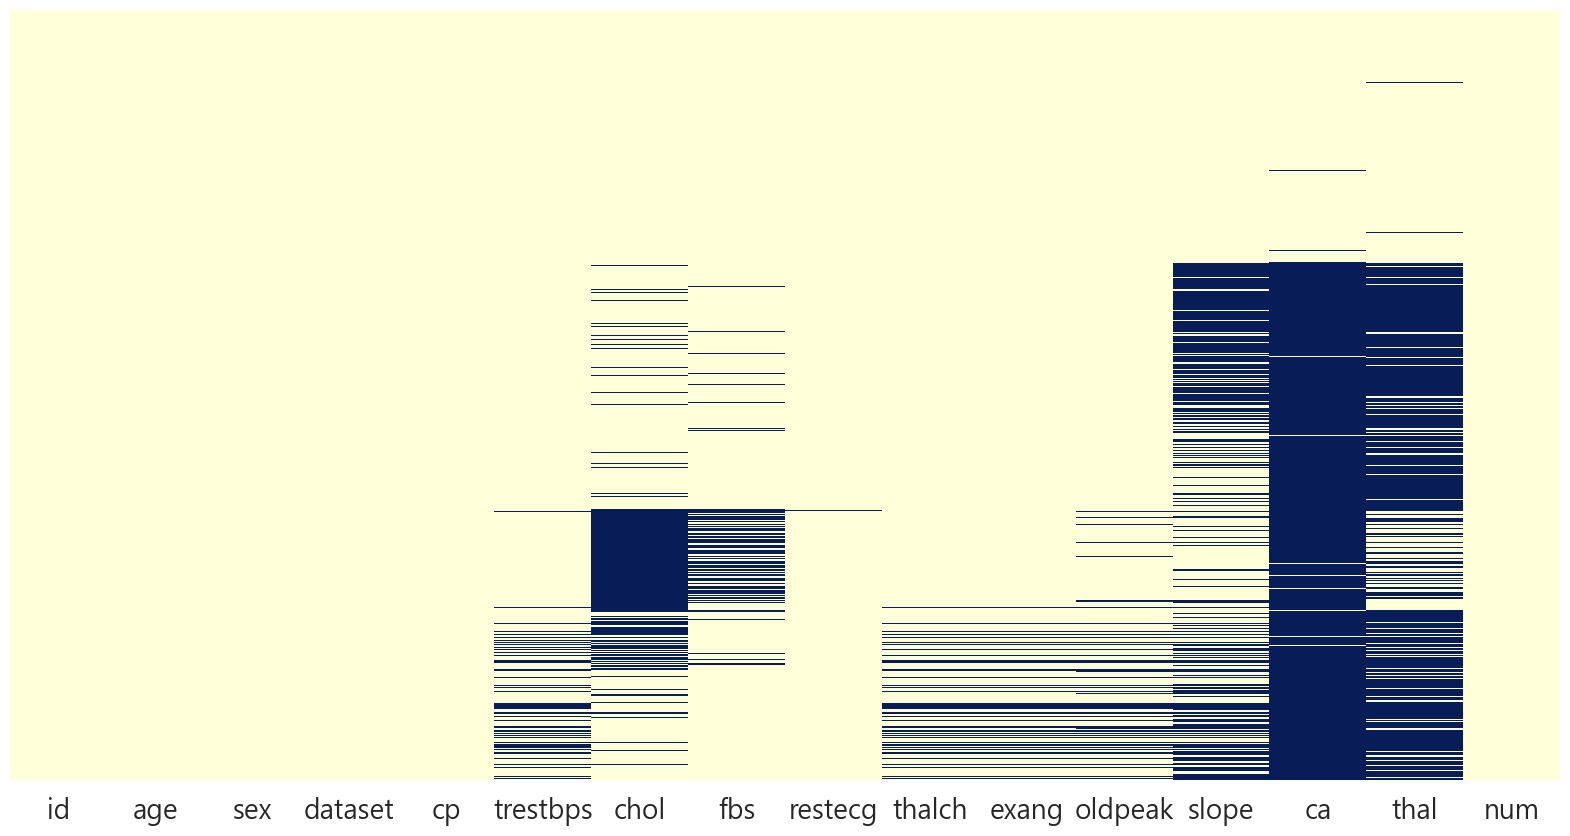

In [196]:
plt.figure(figsize = (20, 10))
sns.heatmap(data = df.isna(), yticklabels = False, cbar = False, cmap = 'YlGnBu')

> 결측치 분포 확인

## Random forest 를 이용한 missing value fillna

> 로직          
1. columns를 numeric, categoric, bool 타입으로 나누어 각각 처리
2. iterativeImputer를 사용하여 RandomForest를 기반으로 결측값을 예측하여 보완

1. columns를 numeric, categoric, bool 타입으로 나누어 각각 처리

In [197]:
df.select_dtypes(include = "number").columns
# ca, num 은 categoric

Index(['id', 'age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca', 'num'], dtype='object')

In [198]:
df.select_dtypes(include = "object").columns
# ca, num

Index(['sex', 'dataset', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal'], dtype='object')

In [199]:
for col in df.columns:
    if True in df[col].values and df[col].dtype != "int64" and df[col].dtype != "float64":
        print(col)

fbs
exang


In [200]:
numeric_cols = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak']
categorical_cols = ['ca', 'num', 'sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']
bool_cols = ['fbs', 'exang']

In [201]:
isna_df_col = []
for col in df.isna().sum()[df.isna().sum() > 0].sort_values(ascending = False).index:
    isna_df_col.append(col)

isna_df_col

['ca',
 'thal',
 'slope',
 'chol',
 'fbs',
 'oldpeak',
 'trestbps',
 'thalch',
 'exang',
 'restecg']

>기본 골자
* iterative_imputer = IterativeImputer(estimator=RandomForestRegressor(random_state= int), add_indicator=True)
* filled_data = iterative_imputer.fit_transform(df)
* filled_df = pd.DataFrame(filled_data, columns=df.columns)

### numeric

In [202]:
for col in numeric_cols:
    label_encoder = LabelEncoder()
    df[col] = label_encoder.fit_transform(df[col])
    
    imputer = IterativeImputer(estimator=RandomForestRegressor(random_state=777), add_indicator=True)
    imputed_values = imputer.fit_transform(df[[col]])
    
    if imputed_values.shape[1] > 1:
        df[f"{col}_추가"] = imputed_values[:, 1]

### categoric

In [203]:
imputed_categorical_dfs = dict()

for col in categorical_cols:
    label_encoder = LabelEncoder()
    df[col] = label_encoder.fit_transform(df[col])
    
    imputer = IterativeImputer(estimator=RandomForestClassifier(random_state=777), add_indicator=True)
    imputed_values = imputer.fit_transform(df[[col]])
    
    if imputed_values.shape[1] == 1:
        column_names = [col]
    else:
        column_names = [col, f"{col}_추가"]
    
    imputed_categorical_df = pd.DataFrame(imputed_values, columns=column_names)

    for col in bool_cols:
        if col in imputed_categorical_df.columns:
            imputed_categorical_df[col] = imputed_categorical_df[col].round().astype(bool)

In [204]:
df.isna().sum()

id          0
age         0
sex         0
dataset     0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalch      0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
num         0
dtype: int64

# Model

## number def

In [205]:
def 수정(values):
    if values == 0:
        return 0
    return 1

df.num = df.num.apply(수정)

## train test

In [206]:
X = df.drop(['num', 'id', 'dataset'], axis=1)
y = df['num']

label_encoder = LabelEncoder()
for col in X.columns:
    if X[col].dtype == 'object' or X[col].dtype == 'category':
        X[col] = label_encoder.fit_transform(X[col])

# split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2 , random_state = 777)

## decision tree

In [207]:
dt = DecisionTreeClassifier(max_depth = 10, random_state = 777)
dt.fit(X_train, y_train)

# predict the test data
y_pred_dt = dt.predict(X_test)

In [208]:
print(classification_report(y_test, y_pred_dt))

              precision    recall  f1-score   support

           0       0.59      0.65      0.62        69
           1       0.78      0.73      0.75       115

    accuracy                           0.70       184
   macro avg       0.68      0.69      0.69       184
weighted avg       0.71      0.70      0.70       184



## random forest

In [209]:
rf = RandomForestClassifier(n_estimators=3000, random_state = 777)
rf.fit(X_train, y_train)

# predict the test data
y_pred_rf = rf.predict(X_test)

In [210]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.75      0.75      0.75        69
           1       0.85      0.85      0.85       115

    accuracy                           0.82       184
   macro avg       0.80      0.80      0.80       184
weighted avg       0.82      0.82      0.82       184



## SVM

In [211]:
svm = SVC(random_state=777)
svm.fit(X_train, y_train)

y_pred_svm = svm.predict(X_test)

In [212]:
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       0.66      0.65      0.66        69
           1       0.79      0.80      0.80       115

    accuracy                           0.74       184
   macro avg       0.73      0.73      0.73       184
weighted avg       0.74      0.74      0.74       184



## xgboost

In [213]:
xgb = XGBClassifier(n_estimators = 100, random_state = 777)
xgb.fit(X_train, y_train)

y_pred_xg = xgb.predict(X_test)

In [214]:
print(classification_report(y_test, y_pred_xg))

              precision    recall  f1-score   support

           0       0.76      0.77      0.76        69
           1       0.86      0.85      0.86       115

    accuracy                           0.82       184
   macro avg       0.81      0.81      0.81       184
weighted avg       0.82      0.82      0.82       184



# Model 평가

In [215]:
tmodel = TSNE(n_components=2)
x_embed = tmodel.fit_transform(X_test)

## Decision Tree

In [216]:
print(classification_report(y_test, y_pred_rf))
fig1 = px.scatter(x_embed[:,0],x_embed[:,1],color=y_test, symbol=y_test, marginal_x = 'histogram', marginal_y = 'rug', trendline = 'ols')
fig1.update_layout(title = 'Actual', coloraxis_showscale=False)
fig1.show()
fig2 = px.scatter(x_embed[:,0],x_embed[:,1],color=y_pred_dt, symbol=y_pred_dt, marginal_x = 'histogram', marginal_y = 'rug', trendline = 'ols')
fig2.update_layout(title = 'Predict', coloraxis_showscale=False)
fig2.show()

              precision    recall  f1-score   support

           0       0.75      0.75      0.75        69
           1       0.85      0.85      0.85       115

    accuracy                           0.82       184
   macro avg       0.80      0.80      0.80       184
weighted avg       0.82      0.82      0.82       184



## Random Forest

In [217]:
print(classification_report(y_test, y_pred_rf))
fig1 = px.scatter(x_embed[:,0],x_embed[:,1],color=y_test, symbol=y_test, marginal_x = 'histogram', marginal_y = 'rug', trendline = 'ols')
fig1.update_layout(title = 'Actual', coloraxis_showscale=False)
fig1.show()
fig2 = px.scatter(x_embed[:,0],x_embed[:,1],color=y_pred_rf, symbol=y_pred_rf, marginal_x = 'histogram', marginal_y = 'rug', trendline = 'ols')
fig2.update_layout(title = 'Predict', coloraxis_showscale=False)
fig2.show()

              precision    recall  f1-score   support

           0       0.75      0.75      0.75        69
           1       0.85      0.85      0.85       115

    accuracy                           0.82       184
   macro avg       0.80      0.80      0.80       184
weighted avg       0.82      0.82      0.82       184



## SVM

In [218]:
print(classification_report(y_test, y_pred_rf))
fig1 = px.scatter(x_embed[:,0],x_embed[:,1],color=y_test, symbol=y_test, marginal_x = 'histogram', marginal_y = 'rug', trendline = 'ols')
fig1.update_layout(title = 'Actual', coloraxis_showscale=False)
fig1.show()


fig2 = px.scatter(x_embed[:,0],x_embed[:,1],color=y_pred_svm, symbol=y_pred_svm, marginal_x = 'histogram', marginal_y = 'rug', trendline = 'ols')
fig2.update_layout(title = 'Predict', coloraxis_showscale=False)
fig2.show()

              precision    recall  f1-score   support

           0       0.75      0.75      0.75        69
           1       0.85      0.85      0.85       115

    accuracy                           0.82       184
   macro avg       0.80      0.80      0.80       184
weighted avg       0.82      0.82      0.82       184



## XGboost

In [219]:
print(classification_report(y_test, y_pred_rf))
fig1 = px.scatter(x_embed[:,0],x_embed[:,1],color=y_test, symbol=y_test, marginal_x = 'histogram', marginal_y = 'rug', trendline = 'ols')
fig1.update_layout(title = 'Actual', coloraxis_showscale=False)
fig1.show()
fig2 = px.scatter(x_embed[:,0],x_embed[:,1],color=y_pred_xg, symbol=y_pred_xg, marginal_x = 'histogram', marginal_y = 'rug', trendline = 'ols')
fig2.update_layout(title = 'Predict', coloraxis_showscale=False)
fig2.show()

              precision    recall  f1-score   support

           0       0.75      0.75      0.75        69
           1       0.85      0.85      0.85       115

    accuracy                           0.82       184
   macro avg       0.80      0.80      0.80       184
weighted avg       0.82      0.82      0.82       184



# # 결측치(Missing value) ver.2

## EDA

In [220]:
df = hdu.copy()

In [221]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB


In [222]:
df = df.drop(columns = {'id', 'dataset'})
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,63,Male,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,67,Male,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,67,Male,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,37,Male,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,41,Female,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [223]:
df_num = df.select_dtypes(include = 'number')
df_num.head(2)

,age,trestbps,chol,thalch,oldpeak,ca,num
0,63,145.0,233.0,150.0,2.3,0.0,0
1,67,160.0,286.0,108.0,1.5,3.0,2


In [224]:
for col in df_num.columns:    
    fig = px.histogram(df_num[col],
                    marginal = 'box',
                    color_discrete_sequence = ['#3F72AF'],
                    nbins = df_num[col].nunique()
                    )
    fig.update_layout(title = col, bargap = 0.1)
    fig.show()

In [225]:
df.loc[df.trestbps == 0, 'trestbps'] = np.nan

In [226]:
df.loc[df.oldpeak < -1.5, 'oldpeak'] = np.nan

In [227]:
df_num.corr()[abs(df_num.corr()) > 0.7]

,age,trestbps,chol,thalch,oldpeak,ca,num
age,1.0,NaN,NaN,NaN,NaN,NaN,NaN
trestbps,NaN,1.0,NaN,NaN,NaN,NaN,NaN
chol,NaN,NaN,1.0,NaN,NaN,NaN,NaN
thalch,NaN,NaN,NaN,1.0,NaN,NaN,NaN
oldpeak,NaN,NaN,NaN,NaN,1.0,NaN,NaN
ca,NaN,NaN,NaN,NaN,NaN,1.0,NaN
num,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [228]:
df.isna().sum()

age           0
sex           0
cp            0
trestbps     60
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      64
slope       309
ca          611
thal        486
num           0
dtype: int64

In [229]:
df.head(2)

,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,63,Male,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,67,Male,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2


## encoding

* dummies = sex
* label = other

In [230]:
df = df.drop(columns = ['sex']).join(pd.DataFrame(pd.get_dummies(df.sex)))

In [231]:
df.num = df.num.apply(수정)

In [232]:
df.head(3)

,age,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num,Female,Male
0,63,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0,False,True
1,67,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,1,False,True
2,67,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1,False,True


In [233]:
for col in df:
    if df[col].dtypes == 'object':
        df[col] = label_encoder.fit_transform(df[col])

## Missing values

* iterative_imputer = IterativeImputer(estimator=RandomForestRegressor(random_state= int), add_indicator=True)
* filled_data = iterative_imputer.fit_transform(df)
* filled_df = pd.DataFrame(filled_data, columns=df.columns)

In [234]:
numeric_cols = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak']
categorical_cols = ['ca', 'num', 'sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']
bool_cols = ['fbs', 'exang']

In [235]:
isna_df_col = []
for col in df.isna().sum()[df.isna().sum() > 0].sort_values(ascending = False).index:
    isna_df_col.append(col)

isna_df_col

['ca', 'oldpeak', 'trestbps', 'thalch', 'chol']

In [236]:
df[['Female', 'Male']] = df[['Female', 'Male']].astype('int')
df.head(10)

,age,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num,Female,Male
0,63,3,145.0,233.0,1,0,150.0,0,2.3,0,0.0,0,0,0,1
1,67,0,160.0,286.0,0,0,108.0,1,1.5,1,3.0,1,1,0,1
2,67,0,120.0,229.0,0,0,129.0,1,2.6,1,2.0,2,1,0,1
3,37,2,130.0,250.0,0,1,187.0,0,3.5,0,0.0,1,0,0,1
4,41,1,130.0,204.0,0,0,172.0,0,1.4,2,0.0,1,0,1,0
5,56,1,120.0,236.0,0,1,178.0,0,0.8,2,0.0,1,0,0,1
6,62,0,140.0,268.0,0,0,160.0,0,3.6,0,2.0,1,1,1,0
7,57,0,120.0,354.0,0,1,163.0,1,0.6,2,0.0,1,0,1,0
8,63,0,130.0,254.0,0,0,147.0,0,1.4,1,1.0,2,1,0,1
9,53,0,140.0,203.0,1,0,155.0,1,3.1,0,0.0,2,1,0,1


### Missing values fill 보완
---
순서도

0. isna(), notna() 나누기
1. dypes 별로 나누기
2. null, notnull 나누기
3. notnull을 X, y로 나누기
4. iterative imputer fit transform (X)
5. 모델 생성
6. X null 로 변경
7. iterative imputer fit transform (X)
8. null = y_pred
9. pd.concat([df_not_null, df_null])  - 결측치 있는 컬럼(isna())들 반복문으로 처리

### 추가
-----       
* **GridSearch Cross Validation**


In [237]:
df.isna().sum()

age           0
cp            0
trestbps     60
chol         30
fbs           0
restecg       0
thalch       55
exang         0
oldpeak      64
slope         0
ca          611
thal          0
num           0
Female        0
Male          0
dtype: int64

In [238]:
for col in isna_df_col:
    if col in numeric_cols:
        df_null = df[df[col].isna()]
        df_not_null = df[df[col].notna()]
        other_cols = [col1 for col1 in isna_df_col if col1 != col]

        X = df_not_null.drop(columns = col)
        y = df_not_null[col]

        iterative_imputer = IterativeImputer(estimator = RandomForestRegressor(n_estimators = 200, random_state = 777), add_indicator = True)

        for col1 in other_cols:
            if X[col1].isnull().sum() > 0:
                col_with_missing_values = X[col1].values.reshape(-1, 1)
                imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
                X[col1] = imputed_values[:, 0]
        else:
            pass

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state = 777)
        
        rf_reg = RandomForestRegressor(n_estimators = 200, random_state = 777)
        rf_reg.fit(X_train, y_train)
        y_pred = rf_reg.predict(X_test)

        X = df_null.drop(columns = col)

        for col1 in other_cols:
            if X[col1].isnull().sum() > 0:
                col_with_missing_values = X[col1].values.reshape(-1, 1)
                imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
                X[col1] = imputed_values[:, 0]
        else:
            pass

        if len(df_null) > 0: 
            df_null[col] = rf_reg.predict(X)
        else:
            pass
        
        df_combined = pd.concat([df_not_null, df_null])
        df[col] = df_combined[col]

    elif col in categorical_cols:
        df_null = df[df[col].isna()]
        df_not_null = df[df[col].notna()]
        other_cols = [col1 for col1 in isna_df_col if col1 != col]

        X = df_not_null.drop(columns = col)
        y = df_not_null[col]

        iterative_imputer = IterativeImputer(estimator = RandomForestClassifier(n_estimators = 200, random_state = 777), add_indicator = True)

        for col1 in other_cols:
            if X[col1].isnull().sum() > 0:
                col_with_missing_values = X[col1].values.reshape(-1, 1)
                imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
                X[col1] = imputed_values[:, 0]
        else:
            pass
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state = 777)

        rf_reg = RandomForestClassifier(n_estimators = 200, random_state = 777)
        rf_reg.fit(X_train, y_train)
        y_pred = rf_reg.predict(X_test)

        X = df_null.drop(columns = col)

        for col1 in other_cols:
            if X[col1].isnull().sum() > 0:
                col_with_missing_values = X[col1].values.reshape(-1, 1)
                imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
                X[col1] = imputed_values[:, 0]
        else:
            pass
        
        if len(df_null) > 0: 
            df_null[col] = rf_reg.predict(X)
        else:
            pass
        
        df_combined = pd.concat([df_not_null, df_null])
        df[col] = df_combined[col]

In [239]:
df.isna().sum()

age         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalch      0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
num         0
Female      0
Male        0
dtype: int64

## Model

In [240]:
X = df.drop(columns = {'num'})
y = df.num

In [241]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state = 777)

### decision tree

In [242]:
from sklearn.model_selection import GridSearchCV


dt_clf = DecisionTreeClassifier(random_state = 777)
dt_clf.fit

# hyperparameter
parameters = {'max_depth': range(1,5), 'min_samples_split': range(2,5)}

# GridSearch Cross Validation
grid_dt = GridSearchCV(dt_clf, param_grid=parameters, cv=5, refit=True, return_train_score=True)
grid_dt.fit(X_train, y_train)

# GridSearchCV result
scores_df = pd.DataFrame(grid_dt.cv_results_)
scores_df[['params', 'mean_test_score', 'rank_test_score',
           'split0_test_score', 'split1_test_score', 'split2_test_score']]

,params,mean_test_score,rank_test_score,split0_test_score,split1_test_score,split2_test_score
0,"{'max_depth': 1, 'min_samples_split': 2}",0.725547,10,0.722973,0.748299,0.734694
1,"{'max_depth': 1, 'min_samples_split': 3}",0.725547,10,0.722973,0.748299,0.734694
2,"{'max_depth': 1, 'min_samples_split': 4}",0.725547,10,0.722973,0.748299,0.734694
3,"{'max_depth': 2, 'min_samples_split': 2}",0.754100,7,0.736486,0.823129,0.707483
4,"{'max_depth': 2, 'min_samples_split': 3}",0.754100,7,0.736486,0.823129,0.707483
5,"{'max_depth': 2, 'min_samples_split': 4}",0.754100,7,0.736486,0.823129,0.707483
6,"{'max_depth': 3, 'min_samples_split': 2}",0.793482,4,0.790541,0.823129,0.809524
7,"{'max_depth': 3, 'min_samples_split': 3}",0.793482,4,0.790541,0.823129,0.809524
8,"{'max_depth': 3, 'min_samples_split': 4}",0.793482,4,0.790541,0.823129,0.809524
9,"{'max_depth': 4, 'min_samples_split': 2}",0.804376,1,0.783784,0.802721,0.829932


In [243]:
# best params
print(f'best params:', grid_dt.best_params_)
print(f'best score {grid_dt.best_score_:.2%}')

best params: {'max_depth': 4, 'min_samples_split': 2}
best score 80.44%


In [244]:
dt = DecisionTreeClassifier(max_depth = 10, random_state = 777)
dt.fit(X_train, y_train)

# predict the test data
y_pred_dt = dt.predict(X_test)

print(classification_report(y_test, y_pred_dt))

              precision    recall  f1-score   support

           0       0.67      0.74      0.70        69
           1       0.83      0.78      0.81       115

    accuracy                           0.77       184
   macro avg       0.75      0.76      0.76       184
weighted avg       0.77      0.77      0.77       184



### random forest

In [245]:
rf = RandomForestClassifier(n_estimators=3000, random_state = 777)
rf.fit(X_train, y_train)

# predict the test data
y_pred_rf = rf.predict(X_test)

print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.76      0.78      0.77        69
           1       0.87      0.85      0.86       115

    accuracy                           0.83       184
   macro avg       0.81      0.82      0.82       184
weighted avg       0.83      0.83      0.83       184



### SVM

In [246]:
svm = SVC(random_state=777)
svm.fit(X_train, y_train)

y_pred_svm = svm.predict(X_test)

print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       0.61      0.68      0.64        69
           1       0.79      0.74      0.77       115

    accuracy                           0.72       184
   macro avg       0.70      0.71      0.70       184
weighted avg       0.73      0.72      0.72       184



### xgboost

In [247]:
xgb = XGBClassifier(n_estimators = 100, random_state = 777)
xgb.fit(X_train, y_train)

y_pred_xg = xgb.predict(X_test)

print(classification_report(y_test, y_pred_xg))

              precision    recall  f1-score   support

           0       0.72      0.86      0.78        69
           1       0.90      0.80      0.85       115

    accuracy                           0.82       184
   macro avg       0.81      0.83      0.81       184
weighted avg       0.83      0.82      0.82       184



## feature importance

### Decision Tree

age: 0.108
cp: 0.066
trestbps: 0.025
chol: 0.096
fbs: 0.004
restecg: 0.039
thalch: 0.102
exang: 0.144
oldpeak: 0.040
slope: 0.008
ca: 0.279
thal: 0.033
num: 0.054
Female: 0.000
--------------------------------------------------


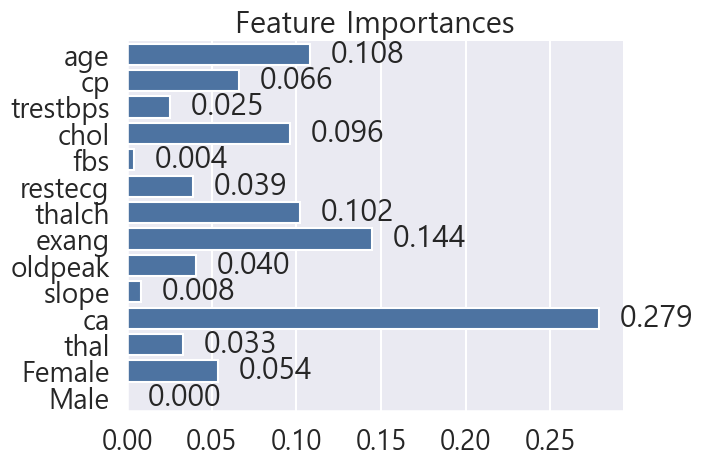

In [248]:
# feature importance 확인
for name, value in zip(df.columns , dt.feature_importances_):
    print(f'{name}: {value:.3f}')

print('-'*50)

# feature importance 시각화
ax = sns.barplot(x = dt.feature_importances_ , y=X.columns, color = '#3F72AF')
ax.bar_label(ax.containers[0], fmt='  %.3f')
plt.gca().spines[['right', 'top']].set_visible(False)
plt.title('Feature Importances')
plt.show()

### Random Forest

age: 0.096
cp: 0.132
trestbps: 0.075
chol: 0.100
fbs: 0.022
restecg: 0.026
thalch: 0.118
exang: 0.083
oldpeak: 0.076
slope: 0.054
ca: 0.129
thal: 0.039
num: 0.026
Female: 0.026
--------------------------------------------------


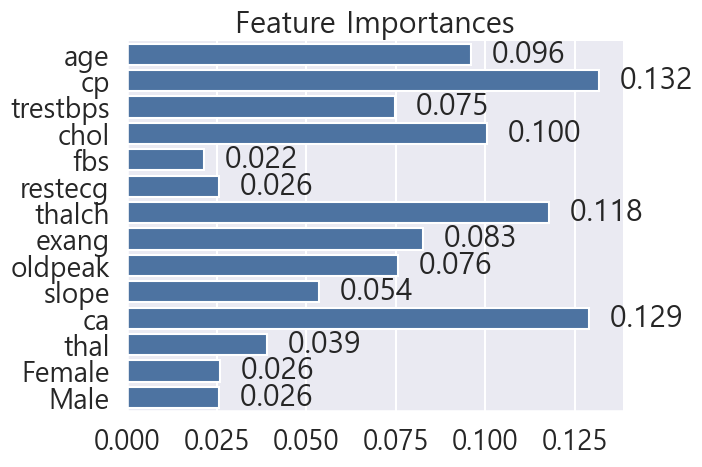

In [249]:
# feature importance 확인
for name, value in zip(df.columns , rf.feature_importances_):
    print(f'{name}: {value:.3f}')

print('-'*50)

# feature importance 시각화
ax = sns.barplot(x = rf.feature_importances_ , y=X.columns, color = '#3F72AF')
ax.bar_label(ax.containers[0], fmt='  %.3f')
plt.gca().spines[['right', 'top']].set_visible(False)
plt.title('Feature Importances')
plt.show()

### xgboost

age: 0.036
cp: 0.073
trestbps: 0.022
chol: 0.028
fbs: 0.026
restecg: 0.035
thalch: 0.030
exang: 0.203
oldpeak: 0.026
slope: 0.045
ca: 0.360
thal: 0.035
num: 0.081
Female: 0.000
--------------------------------------------------


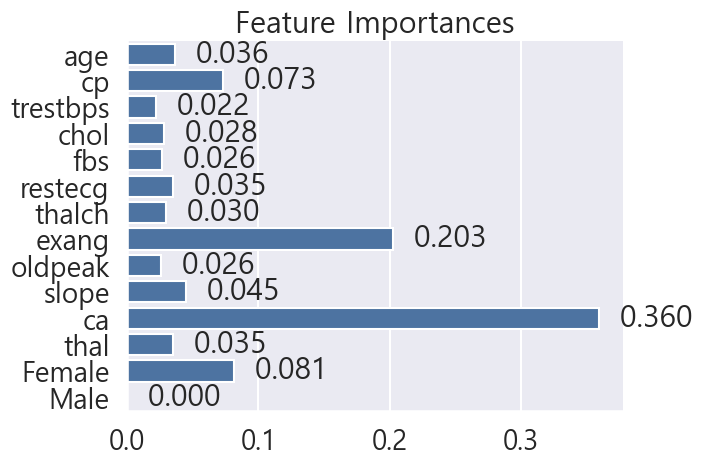

In [250]:
# feature importance 확인
for name, value in zip(df.columns , xgb.feature_importances_):
    print(f'{name}: {value:.3f}')

print('-'*50)

# feature importance 시각화
ax = sns.barplot(x = xgb.feature_importances_ , y=X.columns, color = '#3F72AF')
ax.bar_label(ax.containers[0], fmt='  %.3f')
plt.gca().spines[['right', 'top']].set_visible(False)
plt.title('Feature Importances')
plt.show()